In [1]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split


from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
train_dir = 'train'
test_dir = 'test'
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',\
           'Common wheat', 'Fat Hen','Loose Silky-bent', 'Maize',\
           'Scentless Mayweed', 'Shepherds Purse',\
           'Small-flowered Cranesbill', 'Sugar beet']

for species in SPECIES:
    print('{} {} images'.format(species, \
                                len(os.listdir(os.path.join\
                                (train_dir, species)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [4]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (4750, 3)


In [5]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [6]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

CPU times: user 1min 22s, sys: 8.1 s, total: 1min 30s
Wall time: 1min 50s


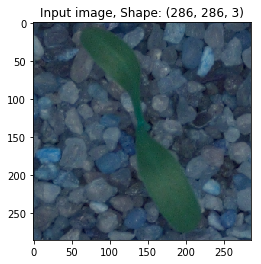

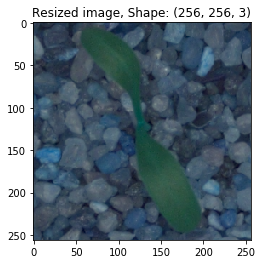

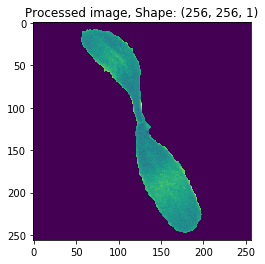

In [7]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [8]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)

In [10]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)
#print(x_train[1])

Input Shape is : (256, 256, 4)


In [11]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(SPECIES), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 16) 1616        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 126, 126, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 126, 126, 16) 2320        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
model_new.compile(optimizer = Adam(lr=.00025) , \
                  loss = 'categorical_crossentropy', \
                  metrics=['accuracy'])

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

In [14]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2,\
                             width_shift_range=0.2, \
                             height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)

In [15]:
model_new.load_weights('model_weights_2.h5f')

In [16]:
batch_size = 32
epochs = 5
#Total epochs: 20 so far

In [17]:
history=  model_new.\
fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), \
              epochs = epochs,validation_data = (x_val,y_val), \
              verbose = 1, steps_per_epoch=x_train.shape[0]\
              // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/5
133/133 [==============================] - 635s 5s/step - loss: 0.5612 - acc: 0.7995 - val_loss: 0.5017 - val_acc: 0.8105
Epoch 2/5
133/133 [==============================] - 635s 5s/step - loss: 0.4751 - acc: 0.8364 - val_loss: 0.3880 - val_acc: 0.8632
Epoch 3/5
133/133 [==============================] - 632s 5s/step - loss: 0.4589 - acc: 0.8350 - val_loss: 0.5694 - val_acc: 0.8232
Epoch 4/5
133/133 [==============================] - 632s 5s/step - loss: 0.4706 - acc: 0.8337 - val_loss: 0.3875 - val_acc: 0.8526
Epoch 5/5
133/133 [==============================] - 631s 5s/step - loss: 0.4285 - acc: 0.8441 - val_loss: 0.4549 - val_acc: 0.8463

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


In [18]:
model_new.save_weights('model_weights_2.h5f', overwrite=True)

In [19]:
%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['test/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)

                 file
0  test/d668409ff.png
1  test/e9cd91682.png
2  test/5315c2dca.png
3  test/0e8492cb1.png
4  test/f48916a8c.png
CPU times: user 12.6 s, sys: 1.36 s, total: 14 s
Wall time: 15.7 s


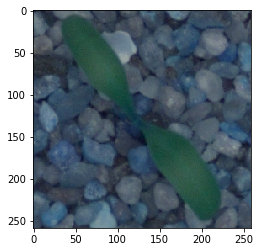

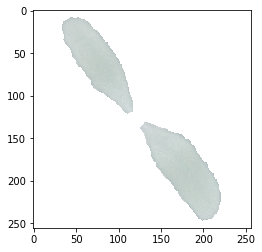

In [20]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()

In [21]:
score = model_new.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])
#Accuracy: 0.86
#Accuracy: 0.84

475/475 [==============================] - 19s 39ms/step
Accuracy on Validation Set 0.8463157898501346


In [22]:
model_feat = Model(inputs=model_new.input, outputs=model_new.get_layer\
                  ('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(4275, 512)
(475, 512)
(794, 512)


In [23]:
svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train, axis=1))

print("Done")

Done


In [24]:
svm.score(feat_train,np.argmax(y_train,axis=1))
#Best Score: 0.8987134502923977
#Best Score1: 0.9263157894736842
#Best Score1: 0.9298245614035088

0.9298245614035088

In [25]:
svm.score(feat_val, np.argmax(y_val,axis=1))
#Best score: 0.871578947368421
#Best score 1: 0.8926315789473684
#Best score 1: 0.9031578947368422

0.9031578947368422

In [26]:
Pred_labels  = svm.predict(feat_test)

In [27]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_xgb.csv', index=False)
#Score: 0.87531
#Score1: 0.89546

            file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet
